In [2]:
#get larlite
from larlite import larlite as ll
from larlite import larutil as lu


geo=lu.Geometry.GetME()
geoH=lu.GeometryHelper.GetME()

import ROOT

In [3]:
#graphics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [4]:
#create storage manager
sm = ll.storage_manager()
sm.set_io_mode(ll.storage_manager.kREAD)
#FILENAME="/Users/ah673/WorkArea/Root6LArLite/UserDev/LArOpenCV/App/mac/pi0_mcc8_output.root" #test_output.root"
FILENAME="/Volumes/UBooNEData/mcc7/cosmics_bnb/ana_files/clusterv4_match_clusterfix_output.root"
#FILENAME="/Volumes/UBooNEData/mcc7/cosmics_bnb/ana_files/clusterv5_linearityFilter_output.root"
sm.add_in_filename(FILENAME)
sm.open()

True

STARTING! 
~~~~~~~~~~~> event is 0 <~~~~~~~~~~~
Algo_pc_Plane_0_clusters
Algo_fm_Plane_0_clusters
Algo_cwo_Plane_0_clusters
Algo_cwo_Plane_0_roi_bounds
Algo_pc_Plane_1_clusters
Algo_fm_Plane_1_clusters
Algo_cwo_Plane_1_clusters
Algo_cwo_Plane_1_roi_bounds
Algo_pc_Plane_2_clusters
Algo_fm_Plane_2_clusters
Algo_cwo_Plane_2_clusters
Algo_cwo_Plane_2_roi_bounds
Done getting 
None
nsbc_clusters 47


TypeError: 'larlite::event_base' object does not support indexing

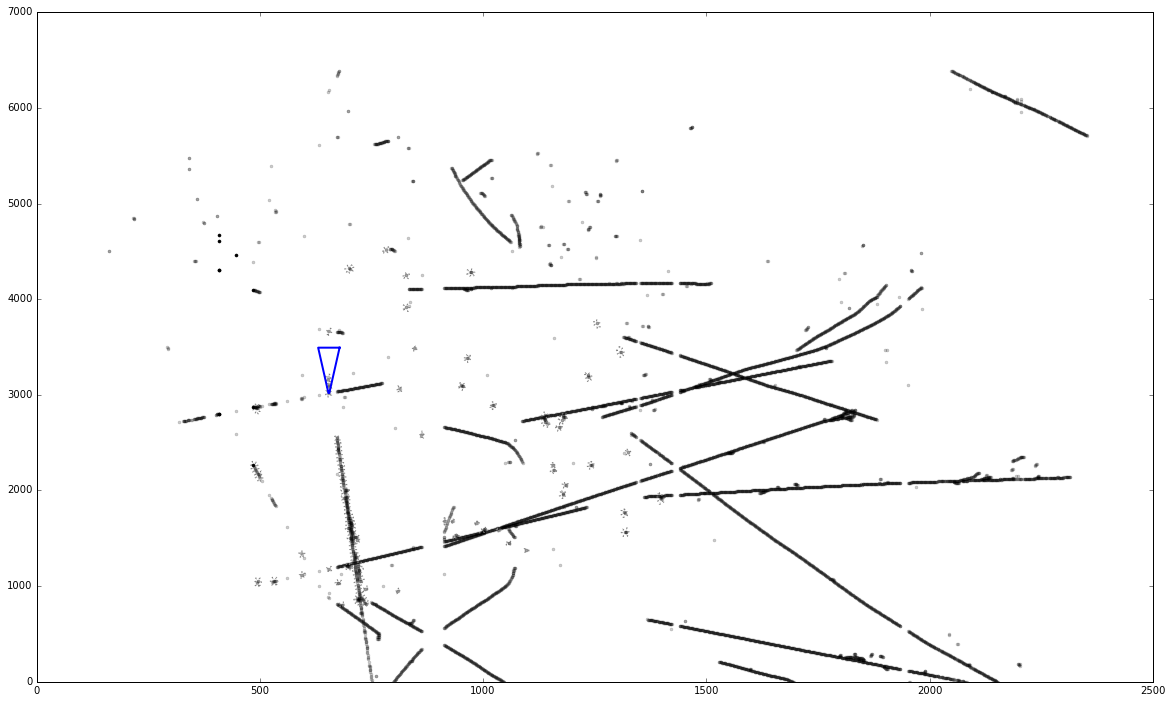

In [5]:
#there is only 1 event
print "STARTING! "
#for evt in xrange(1050):
while True:
    evt = 0
    print "~~~~~~~~~~~> event is %d <~~~~~~~~~~~"%evt
    
    sm.go_to(evt)

    #get hits and clusters
    event_hits     = sm.get_data(ll.data.kHit,"hit02")
    event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")

    #get ass
    event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")

    #get association
    cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())

    #get the vertex_data
    event_vertex = sm.get_data(ll.data.kVertex,"mcvertex") #numuCC_vertex")

    #get contour data
    event_user = sm.get_data(ll.data.kUserInfo,"ImageClusterHit")

    for e in xrange(event_user.size()):
        eu = event_user[e]
        print eu.get_string("ID")
        
    
    print "Done getting "
    
    import root_numpy as rn
    gausdata = rn.root2array(FILENAME,
                            treename='hit_gaushit_tree',
                            branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

    import pandas as pd
    hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                           'PeakTime'  : gausdata[evt][0],
                           'Plane'     : gausdata[evt][2]})


    #User info contains lots of stuff, but lets filter it by ID string
    sbcplane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_0_clusters'][0]
    sbcplane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_1_clusters'][0]
    sbcplane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_2_clusters'][0]
    
    #User info contains lots of stuff, but lets filter it by ID string
    plane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_0_clusters'][0]
    plane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_1_clusters'][0]
    plane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_2_clusters'][0]
 
    #convex hull per cluster
    roiplane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_0_roi_bounds'][0]
    roiplane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_1_roi_bounds'][0]
    roiplane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_2_roi_bounds'][0]

    #Show the ImageClusters
    for plane in [0,1,2]:
        sbc_data=event_user[plane]
        hsv = plt.get_cmap('jet')
        lors = hsv(np.linspace(0, 1.0, cluster_to_hit_ass.size()))

        fig,ax=plt.subplots(figsize=(10*2,6*2))

        phits = hits_df.query("Plane=={}".format(plane))

        ax.plot(phits.Wire,phits.PeakTime,'o',color='black',markersize=3,alpha=0.2)
    
       
        exec("sbc_data = sbcplane%s"%plane)
        nsbc_clusters = sbc_data.get_int("NClusters")
        
        print sbc_data.dump_contents()
        print "nsbc_clusters",nsbc_clusters
        for c in xrange(nsbc_clusters):
    
            xx=np.array(sbc_data.get_darray('ClusterID_{}_contour_x'.format(c)))
            yy=np.array(sbc_data.get_darray('ClusterID_{}_contour_y'.format(c)))

            xx=np.append(xx,xx[0])
            yy=np.append(yy,yy[0])

            plt.plot(yy,xx,':',lw=2,color='Grey')
        
        
        # plot each cluster and userinfo
        for ix,cluster in enumerate(cluster_to_hit_ass):

            ##############################
            #get the hits for this clusters
            slice_=np.array(cluster)
            if event_clusters[ix].Plane().Plane != plane: continue
            if slice_.size == 0: continue

            hslice = hits_df.iloc[slice_]
            ax.plot(hslice.Wire,hslice.PeakTime,'o',color='black',markersize=3)

            ##############################
            #call user_info get_darray, for the contour   

            exec("cluster_data = plane%s"%plane)

            cid = event_clusters[ix].ID()
            xx=np.array(cluster_data.get_darray('ClusterID_{}_contour_x'.format(cid)))
            yy=np.array(cluster_data.get_darray('ClusterID_{}_contour_y'.format(cid)))

            xx=np.append(xx,xx[0])
            yy=np.append(yy,yy[0])

            plt.plot(yy,xx,'-',lw=2)

            ##############################
            #put vertex information on screen as a big star 

            vtx=ROOT.std.vector('double')()
            vtx.resize(3)
            vtx[0]=event_vertex[0].X()
            vtx[1]=event_vertex[0].Y()
            vtx[2]=event_vertex[0].Z()
            px = geoH.Point_3Dto2D(vtx.data(),plane)
            pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])

            ax.plot(pt[0],pt[1],'*',markersize=15,color='yellow')

            ##############################
            #can we overlay the start points?
            startx = cluster_data.get_double("ClusterID_{}_startPt_x".format(cid))
            starty = cluster_data.get_double("ClusterID_{}_startPt_y".format(cid))
            ax.plot(starty,startx,'*',markersize=15,color='orange')
            
            endx = cluster_data.get_double("ClusterID_{}_endPt_x".format(cid))
            endy = cluster_data.get_double("ClusterID_{}_endPt_y".format(cid))
            ax.plot(endy,endx,'*',markersize=15,color='purple')
            
            dist_tmp = math.sqrt(pow((startx - pt[1])*geoH.TimeToCm(),2) \
                               + pow((starty - pt[0])*geoH.WireToCm(),2) )
            
            len_tmp = math.sqrt(pow((startx-endx)*geoH.TimeToCm(),2) \
                              + pow((starty-endy)*geoH.WireToCm(),2))
            
            print "Dist: ", dist_tmp, "; Length : ", len_tmp
            
            
        exec("roi_data = roiplane%s"%plane)  
        ##############################
        #put the bounding box in

        bbx=np.array(roi_data.get_darray('roi_bounds_x'))
        bby=np.array(roi_data.get_darray('roi_bounds_y'))

        bbx=np.append(bbx,bbx[0])
        bby=np.append(bby,bby[0])
        plt.plot(bbx,bby,'-',lw=2,color='brown')

        ax.set_xlim(bbx.min()-25,bbx.max()+25)
        ax.set_ylim(bby.min()-25,bby.max()+25)

        plt.grid()
        ax.set_title("Event {} Plane {}".format(evt,plane),fontweight='bold',fontsize=30)
        #plt.savefig("event_{}_plane_{}.png".format(evt,plane))
        plt.show()
    break

In [ ]:
import math 

print math.cos(0.7) * 180 / math.pi
print math.cos(0.72) * 180 / math.pi
print math.cos(0.98) * 180 / math.pi